In [49]:
# Let's import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# Create the dataframe with the CSV file provided by the company. As the CSV has missing values, we will use onbad_lines='skip'
df = pd.read_csv('marketingcampaigns.csv', on_bad_lines='skip')

In [51]:
#Display the dataframe
df

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.3,0.35,email,B2B,organic,0.40,709593.48
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.1,0.37,podcast,B2B,paid,0.28,458227.42
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.9,0.30,social media,B2B,promotion,0.81,47511.35
...,...,...,...,...,...,...,...,...,...,...
1027,No revenue campaign,2023-02-01,2023-08-01,20000,0.30,social media,B2B,organic,0.50,NaN
1028,Random mess,2023-06-06,NaN,100000,NaN,podcast,NaN,referral,NaN,300000.00
1029,Invalid budget,2022-12-01,2023-06-01,abc,NaN,email,B2C,promotion,0.20,50000.00
1030,Overlapping dates,2023-03-01,2022-12-31,60000,0.60,webinar,B2B,paid,0.70,90000.00


In [ ]:
# Let's do some basic analysis: such as check the datatypes, the null values and some basic statistics
print('The datatypes of the columns are: ')
print(df.dtypes)
print('\nThe null values in the columns are: ')
print(df.isnull().sum())
print('\nThe basic statistics of the columns are: ')
df.describe().T

The datatypes of the columns are: 
campaign_name       object
start_date          object
end_date            object
budget              object
roi                float64
type                object
target_audience     object
channel             object
conversion_rate    float64
revenue            float64
dtype: object

The null values in the columns are: 
campaign_name      0
start_date         1
end_date           2
budget             3
roi                4
type               1
target_audience    2
channel            1
conversion_rate    4
revenue            3
dtype: int64

The basic statistics of the columns are: 


,count,mean,std,min,25%,50%,75%,max
roi,1028.0,0.533804,0.261869,-0.20,0.31,0.53,0.76,0.99
conversion_rate,1028.0,0.541936,0.267353,0.00,0.30,0.55,0.77,1.50
revenue,1029.0,511591.195277,287292.729847,108.21,267820.25,518001.77,765775.14,999712.49


Just by analyzing above data, we can see a few thing we need to take care of:
- We need to make sure that dates are in the correct format (currenly object when it should be datetime).
- We need to make sure budget is in the correct format (currenly object when it should be float).

Before changing anything, let's see what values have the columns that are in the wrong format

In [ ]:
# Since budget column should be numeric, let's check if there are any non-numeric values in the Budget column

non_numeric_budget = df[~pd.to_numeric(df['budget'], errors='coerce').notnull()]
print(non_numeric_budget[['budget']])


     budget
1003    NaN
1005    NaN
1024    NaN
1029    abc


In [ ]:
# Now let's check date columns. The columns 'start_date' and 'end_date' should be in datetime format. Let's check if they are in the correct format.
non_datetime_start_date	 = df[~pd.to_datetime(df['start_date'], errors='coerce').notnull()]
non_datetime_end_date = df[~pd.to_datetime(df['end_date'], errors='coerce').notnull()]
print(non_datetime_start_date[['start_date']])
print('\n')
print(non_datetime_end_date[['end_date']])

      start_date
1006  2023-13-01
1021         NaN
1022  2023-13-01


        end_date
1006  2024-02-30
1024         NaN
1028         NaN


- Values that are not in the correct format for budget column: 3 nulls and one value which is not part of any of the other columns.
- Values that are not in the correct format for dates columns: 3 nulls, one date which does not exist and 2 dates with the wrong structure (YYY-DD-MM instead of YYYY-MM-DD). 

Knowing this, we can proceed to fix the columns.

In [55]:
# # First step is to check those rows (where the wrong dates are) and check the values so we can take the right decision
df.iloc[[1006, 1022]]

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1006,Typo in Date,2023-13-01,2024-02-30,50000.0,0.65,webinar,B2C,promotion,0.9,320000.0
1022,Broken-date campaign,2023-13-01,2024-01-01,25000,0.45,email,B2B,organic,NaN,87500.0


We can see from above table:
- Row 1006: Since the row is fine we take the decision to change the end_date to 2024-03-01. This decision has been taken because is more likely that the end_date is a formula of start_date + X days. We will put the right format on start_date as well.
- Row 1022: Rest of the data is completely fine. We will put the right format on start_date.

In [ ]:
# Let's modify the values for rows 1006 and 1022 in "start_date" to get YYYY-MM-DD instead of YYYY-DD-MM 
# and also in row 1006 the value in column end_date to get 2024-03-01 instead of 2024-02-30
df.loc[1006, 'start_date'] = '2024-01-13'
df.loc[1022, 'start_date'] = '2024-01-13'
df.loc[1006, 'end_date'] = '2024-03-01'

Now we can proceed to fix the columns. The only value we will discard in the "abc" on budget column

In [57]:
# Now let's change the format in columns start_date, end_date and budget to the correct format
df['start_date'] = pd.to_datetime(df['start_date'], format='%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')

Now, we should have the correct format for all columns. Let's check the datatypes again to make sure everything is in order and also the basic statics we checked before.

In [ ]:
print('The datatypes of the columns are: ')
print(df.dtypes)
print('\nThe null values in the columns are: ')
print(df.isnull().sum())
print('\nThe basic statistics of the columns are: ')
df.describe().T

The datatypes of the columns are: 
campaign_name              object
start_date         datetime64[ns]
end_date           datetime64[ns]
budget                    float64
roi                       float64
type                       object
target_audience            object
channel                    object
conversion_rate           float64
revenue                   float64
dtype: object

The null values in the columns are: 
campaign_name      0
start_date         1
end_date           2
budget             4
roi                4
type               1
target_audience    2
channel            1
conversion_rate    4
revenue            3
dtype: int64

The basic statistics of the columns are: 


,count,mean,min,25%,50%,75%,max,std
start_date,1031,2023-01-31 06:29:40.795344384,2022-08-02 00:00:00,2022-10-31 00:00:00,2023-01-29 00:00:00,2023-04-30 00:00:00,2025-01-01 00:00:00,NaN
end_date,1030,2024-01-30 01:49:02.912621312,2022-12-31 00:00:00,2023-11-01 00:00:00,2024-01-27 12:00:00,2024-05-03 18:00:00,2025-06-01 00:00:00,NaN
budget,1028.0,58995.980506,-10000.0,24735.4925,46948.235,74923.65,9999999.0,311694.946084
roi,1028.0,0.533804,-0.2,0.31,0.53,0.76,0.99,0.261869
conversion_rate,1028.0,0.541936,0.0,0.3,0.55,0.77,1.5,0.267353
revenue,1029.0,511591.195277,108.21,267820.25,518001.77,765775.14,999712.49,287292.729847


Now the dataset looks much better, and we have only one more null (the old "abc" value in budget column). 

In [59]:
df

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.90,0.30,social media,B2B,promotion,0.81,47511.35
...,...,...,...,...,...,...,...,...,...,...
1027,No revenue campaign,2023-02-01,2023-08-01,20000.00,0.30,social media,B2B,organic,0.50,NaN
1028,Random mess,2023-06-06,NaT,100000.00,NaN,podcast,NaN,referral,NaN,300000.00
1029,Invalid budget,2022-12-01,2023-06-01,NaN,NaN,email,B2C,promotion,0.20,50000.00
1030,Overlapping dates,2023-03-01,2022-12-31,60000.00,0.60,webinar,B2B,paid,0.70,90000.00


Let's check now all values:
- end_date must be after start_date.
- Categoric values must have the correct values (no mixed values).

In [63]:
# Let's check end_date is greater than start_date.
df_dates_check = df[df['end_date'] < df['start_date']]
df_dates_check

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1022,Broken-date campaign,2024-01-13,2024-01-01,25000.0,0.45,email,B2B,organic,NaN,87500.0
1030,Overlapping dates,2023-03-01,2022-12-31,60000.0,0.60,webinar,B2B,paid,0.7,90000.0


So we can see there are two lines where the start_date is after the end_date. Let's check now the categoric values.

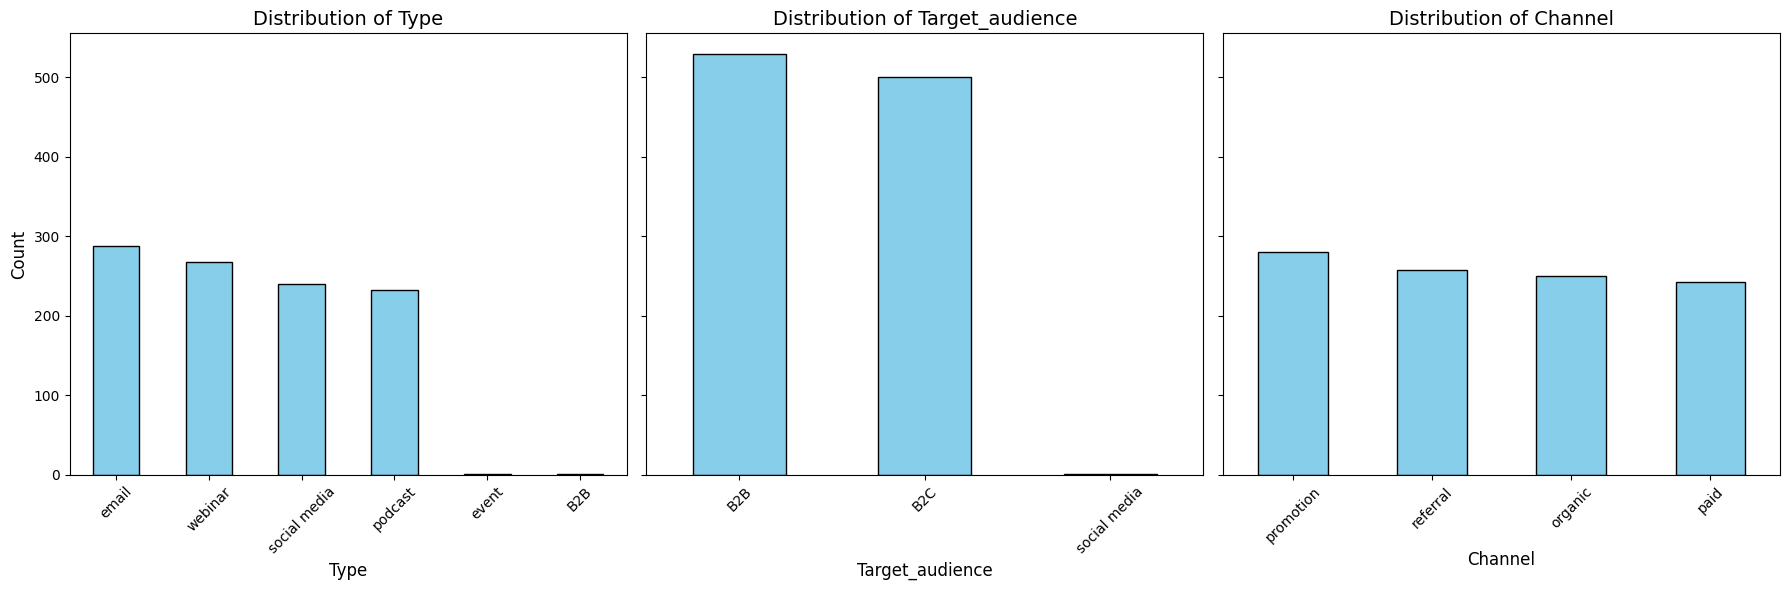

In [65]:
# Let's use a bar plot to visualize the distribution of the categorical columns in the dataset. 
# Then we can focus on those which have a lower number of values to check if they really belong to that column.

categorical_columns = ['type', 'target_audience', 'channel']

fig, axes = plt.subplots(1, len(categorical_columns), figsize=(18, 6), sharey=True)

for i, col in enumerate(categorical_columns):
    df[col].value_counts().plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col.capitalize()}', fontsize=14)
    axes[i].set_xlabel(col.capitalize(), fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Having a quick look at the date, it is easy to identify some mistakes: there is a "social media" value in the target_audience column and a "B2B" value in the Type column.
Let's analyze them

In [66]:
# Let's see the rows with the wrong values in the column 'type'
df_filtered = df[df['type'] == 'B2B']
df_filtered

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1024,Null-heavy campaign,2023-01-01,NaT,NaN,NaN,B2B,social media,NaN,NaN,NaN


We can see that the row which contains the wrong value in the column 'type' is the same that contains the wrong value in the column 'target_audience'.

So far, as a summary, we have:
- 2 rows with the start_date after the end_date.
- 1 row with the values interchanged which is not providing any value at all since the rest of the values are null. Therefore we will drop this row.

In [68]:
# We will drop row 1024
df = df.drop(index=1024)

Now let's check if there are duplicate rows.

In [75]:
# Let's check duplicate rows in the dataset
duplicates = df[df.duplicated(keep=False)]
duplicates.sort_values(by='campaign_name', ascending=True)

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1001,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
1011,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
11,Cross-platform demand-driven encoding,2023-07-21,2023-11-04,64041.37,0.16,social media,B2B,promotion,0.55,174462.47
1020,Cross-platform demand-driven encoding,2023-07-21,2023-11-04,64041.37,0.16,social media,B2B,promotion,0.55,174462.47
1010,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
1002,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
1012,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73


In [79]:
# Let's count the duplicated rows
duplicates_count = df.duplicated(keep=False).sum()
duplicates_count

np.int64(27)

Podemos ver que hay 27 lineas duplicadas por completo.